In [1]:
import pandas as pd
#from pmdarima.arima import auto_arima
import prophet
#85 percent train 15 percent test

Importing plotly failed. Interactive plots will not work.


In [7]:
prophet.Prophet()

In [2]:
df = pd.read_csv('variable_selected_county_dataset.csv', index_col=0)

In [4]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tools.sm_exceptions import ValueWarning
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller

data = pd.read_csv('variable_selected_county_dataset.csv').iloc[:, 1:]


def difference(df):
    df['incremental_cases'] = df['incremental_cases'].diff().fillna(df['incremental_cases'])
    return df


miami = data[data['entity'] == 'Florida-Miami-Dade'].loc[:, ['date', 'incremental_cases']]
miami['incremental_cases'] = miami['incremental_cases'].astype('int')
miami['date'] = pd.to_datetime(miami['date'], format="%Y-%m-%d")

# use 85%-15% for train-test split
train = miami.iloc[:230, :]
test = miami.iloc[230:, :]

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

# NYC data is stationary without any differencing
stationary_test(train.incremental_cases)

(-1.642344912578238, 0.4610357721284504)

In [5]:
arimaModel = miami[['date', 'incremental_cases']]
arimaModel.rename(columns={"date": "ds", "incremental_cases": "y"}, inplace=True)
train = arimaModel.head(int(0.85*len(arimaModel))+1)
test = arimaModel.tail(int(0.15*len(arimaModel)))

In [17]:
train

,ds,y
1620,2020-03-10,2
1621,2020-03-11,9
1622,2020-03-12,13
1623,2020-03-13,10
1624,2020-03-14,28
...,...,...
1845,2020-10-21,133
1846,2020-10-22,77
1847,2020-10-23,101
1848,2020-10-24,161


17:41:53 - cmdstanpy - INFO - Chain [1] start processing
17:41:53 - cmdstanpy - INFO - Chain [1] done processing


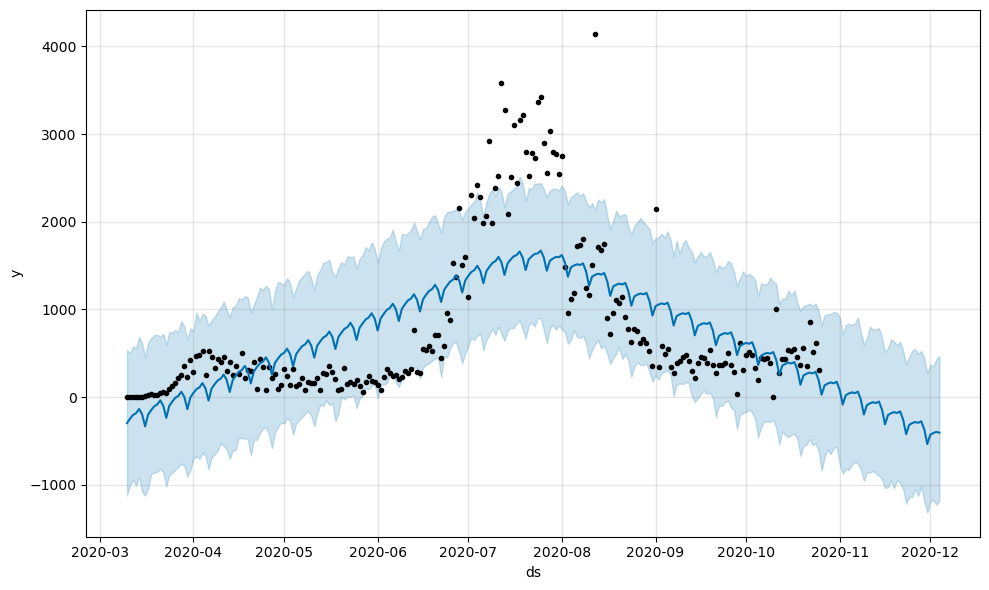

In [6]:
baseModel = prophet.Prophet().fit(train)
future = baseModel.make_future_dataframe(periods=40)
forecast = baseModel.predict(future)
baseModel.plot(forecast);

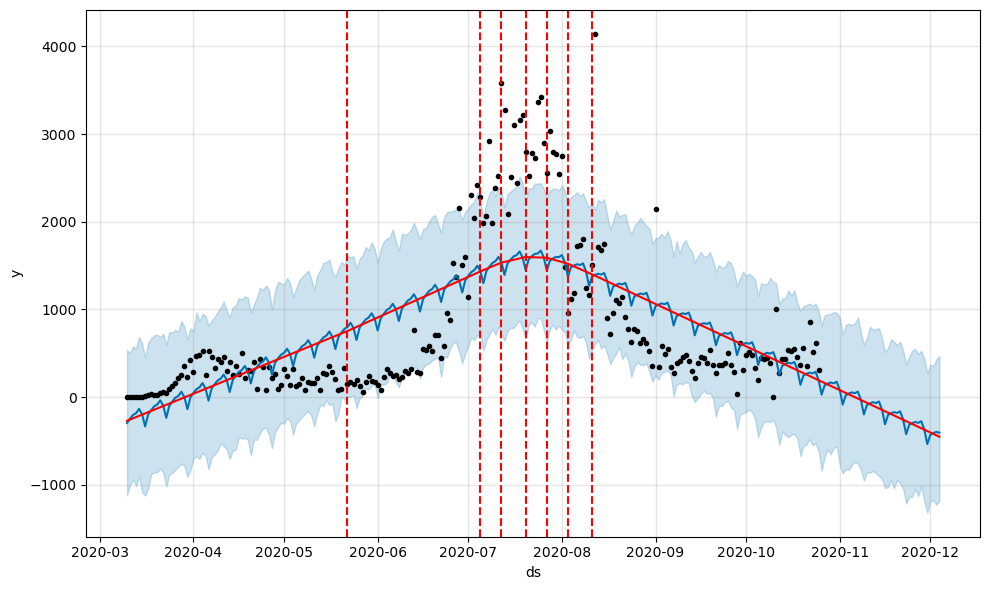

In [7]:
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = baseModel.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), baseModel, forecast)

In [7]:
import statsmodels.api as sm

In [9]:
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,
})

# Super Bowl time window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2020-02-02']),
    'lower_window': -7,
    'upper_window': 1,
})

# Combine all events
events = pd.concat((COVID, superbowl))

In [22]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

#train.reset_index(inplace=True)

n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

changepoint_prior_scale = [0.001, 0.01, 0.1, 0.5]
seasonality_prior_scale =  [0.01, 0.1, 1.0, 10.0]
holidays_prior_scale = [0.01, 0.1, 1.0, 10.0]
seasonality_mode = ['additive', 'multiplicative']

best_score, best_cfg = float("inf"), None


    
for h in holidays_prior_scale:
    for c in changepoint_prior_scale:
        for s in seasonality_prior_scale:
            for m in seasonality_mode:
                avg = 0
                for train_index, val_index in tscv.split(train):
                    train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
                    model=prophet.Prophet(holidays=events, holidays_prior_scale=h, changepoint_prior_scale=c, seasonality_prior_scale=s,
                                         seasonality_mode = m)
                    model.add_country_holidays(country_name='US')
                    model.fit(train_data)
                    future = model.make_future_dataframe(periods=val_data.shape[0])
                    future = future[future['ds'] > train_data.ds.iloc[-1]]
                    forecast = model.predict(future)
                    mse = mean_squared_error(val_data.y, forecast.yhat)
                    avg += mse
                if avg < best_score:
                    best_score, best_cfg = avg, (h,c,s,m)

print(f'Best ARIMA parameters: {best_cfg} with MSE: {best_score}')

17:35:12 - cmdstanpy - INFO - Chain [1] start processing
17:35:12 - cmdstanpy - INFO - Chain [1] done processing
17:35:12 - cmdstanpy - INFO - Chain [1] start processing
17:35:12 - cmdstanpy - INFO - Chain [1] done processing
17:35:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:35:12 - cmdstanpy - INFO - Chain [1] start processing
17:35:13 - cmdstanpy - INFO - Chain [1] done processing
17:35:13 - cmdstanpy - INFO - Chain [1] start processing
17:35:13 - cmdstanpy - INFO - Chain [1] done processing
17:35:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:35:13 - cmdstanpy - INFO - Chain [1] start processing
17:35:14 - cmdstanpy - INFO - Chain [1] done processing
17:35:14 - cmdstanpy - INFO - Chain [1] start processing
17:35:15 - cmdstanpy - INFO - Chain [1] done processing
17:35:15 -

Best ARIMA parameters: (0.1, 0.01, 0.1, 'multiplicative') with MSE: 5424394.652828984


17:40:46 - cmdstanpy - INFO - Chain [1] start processing
17:40:47 - cmdstanpy - INFO - Chain [1] done processing


-0.0774451575752082


<Axes: xlabel='ds'>

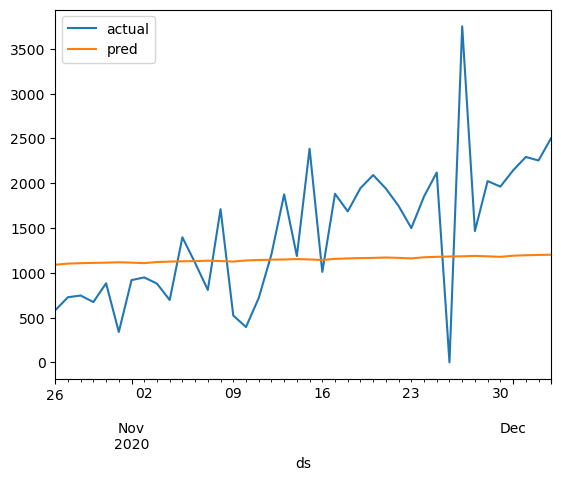

In [23]:


model=prophet.Prophet(holidays=events, holidays_prior_scale=0.1, changepoint_prior_scale=0.01, seasonality_prior_scale=0.1,
                                         seasonality_mode = 'multiplicative')
model.add_country_holidays(country_name='US')
model.fit(train)
future = model.make_future_dataframe(periods=40)
future = future[future['ds'] > train.ds.iloc[-1]]
pred = model.predict(future)


r2 = r2_score(test.y, pred.yhat)
print(r2)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True), 
              'pred':pred.yhat.reset_index(drop = True)})
prediction['ds'] = test['ds'].reset_index(drop = True)
prediction.plot(x = 'ds', y = ['actual', 'pred'])